# Quant basics

Bem vindo ao projetinho do Turing Quant!

Neste notebook você aprenderá os seguinte assuntos:

- Importação de dataset de preço históricos
- Retornos e Risco (Volatilidade)
- Lidando com portfolios
- Predição de Series Temporais
- Implementação TSMOM

## 1. Importação de dataset de preço histórico

Para a importação de dados existem diversas bibliotecas em python que fornem preços históricos de ativos

Detre elas podemos citar as seguinte plataformas:

- Google Finance (Via panda_datareader)
- Yahoo Finace (Via panda_datareader)
- Quandl

Pesquise sobre como importar dados nessas bibliotecas. Os dataset que consiguimos com essas bibliotecas são denominados OHLCV (open-high-low-close-volume).

- Plote os preços de fechamento
- Plote um gráfico de vela
- Faça uma simples analise qualitativa do ativo escolhido (Ex: porque ele teve grande variação em algum momento)

In [1]:
# importando biliotecas para manipulação, calculo e plotagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from pandas_datareader import data

# Importando dataset de preços da apple
df = data.DataReader('TSLA', 
                     start='2016-1-1',
                     end='2020-4-22',
                     data_source='yahoo')

In [7]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,231.380005,219.000000,230.720001,223.410004,6827100,223.410004
2016-01-05,226.889999,220.000000,226.360001,223.429993,3186800,223.429993
2016-01-06,220.050003,215.979996,220.000000,219.039993,3779100,219.039993
2016-01-07,218.440002,213.669998,214.190002,215.649994,3554300,215.649994
2016-01-08,220.440002,210.770004,217.860001,211.000000,3628100,211.000000


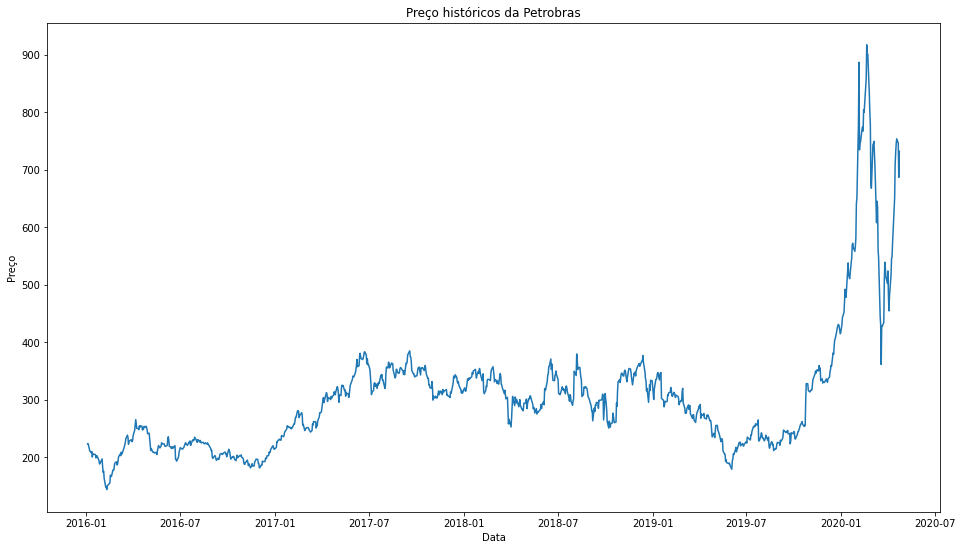

In [8]:
df_close = df["Close"]

plt.figure(figsize=(16,9))

plt.plot(df_close)

plt.title("Preço históricos da Petrobras")
plt.ylabel("Preço")
plt.xlabel("Data")

plt.show()


In [9]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df["Open"],
                                     high=df["High"],
                                     low=df["Low"],
                                     close=df["Close"])])

fig.show()

## Análise qualitativa

Responda aqui no markdown...

# 2. Retorno e Risco

Inserir intro

Com o mesmo ativo que você importou anteriormente, iremos inicial os calculos de risco e retorno. Porém inicialmente iremos analisar retorno e risco com o preço de fechamento.

Há duas maneiras de se calcular o retorno de uma série temporal

- Retorno Simples: $R_t = (P_t - P_{t-1})/P_{t-1} = P_t/P_{t-1} - 1$
- Retorno Logaritmo: $r_t = log(P_t/P{t-1}) = log(P_t) - log(P_{t-1})$

Sendo $P_t$ o preço no tempo t, e $P_{t-1}$ preço no tempo $t-1$ (Dia anterior).

Manipulando o dataframe implemente esse dois tipos de retonos e compare-os

Calcule os retornos cumulativos deles

- Retorno Cumulatvo: $R_{cum} = (1+R_t) * (1+R_{t-1})$

#### Recomendação: Na medida do possível minimize a utilização de for loops, sempre tente usar numpy para os cálculos, pois essa biblioteca é muito eficiente

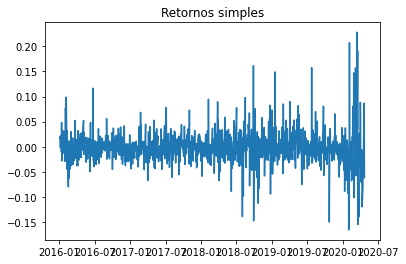

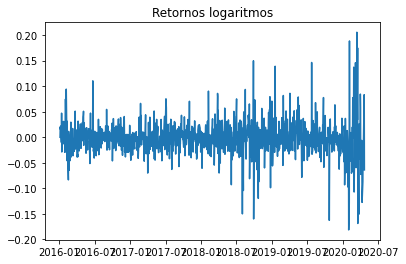

In [10]:
R_simple = np.divide(df_close, df_close.shift(-1)) -1
r_log = np.log(np.divide(df_close, df_close.shift(-1)))

plt.plot(R_simple)
plt.title("Retornos simples")
plt.show()

plt.plot(r_log)
plt.title("Retornos logaritmos")
plt.show()

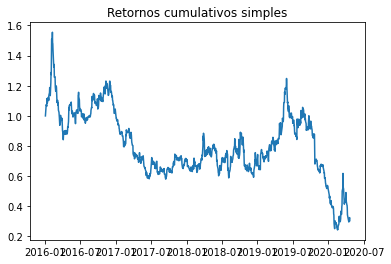

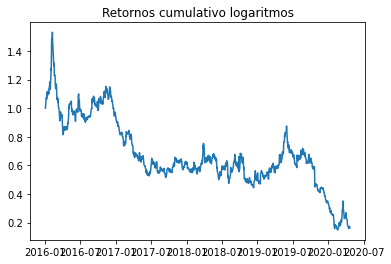

In [11]:
plt.plot((1+R_simple).cumprod())
plt.title("Retornos cumulativos simples")
plt.show()

plt.plot((1+r_log).cumprod())
plt.title("Retornos cumulativo logaritmos")
plt.show()

# Risco

Há diversos tipo de definições de risco, em finança quantitativas uma maneira bem fácil de calcular o risco é a partir da variação do ativo. Básicamento você não quer investir num ativo que varia muito, ou seja, muito imprevisivel. Uma maneira estátistica de cálcular a essa volatilidade é a partir do desvio padrão.

- Calcule o desvio padrão do ativo

Apenas o valor do desvio padrão não apresenta muita informação, então iremos calcular o rolling std. Básicamente iremos calcular o desvio padrão a cada t intervalo de tempo.

- Calcule o rolling std

Dica: utilize o método ```pandas.rolling(window).std()``` do pandas, window é o intervalo em que você irá calcular o desvio padrão

### Desafio

- Calcule o desvio padrão exponencial (EWMA)
- Calcule o desvio padrão estimado pelo High e Low (Parkinson Number)
- Calcule o desvio padrão estimado por High, Low, Close e Open (Garman-Klass)

In [12]:
df_close.std()

110.77392593316779

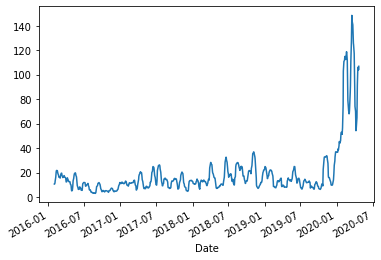

In [13]:
df_close.rolling(20).std().plot()

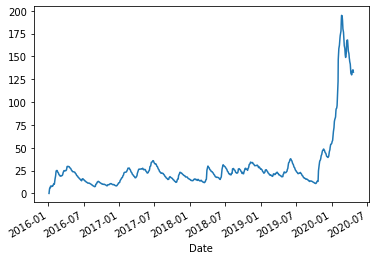

In [14]:
df_close.ewm(20).std().plot()

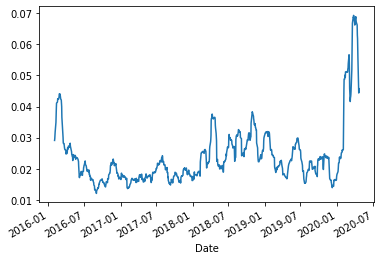

In [15]:
def parkinson_vol(high_df, low_df, period=60):

    x = np.log(np.divide(high_df, low_df)) ** 2

    pv = x.copy()

    const = 1 / (4 * period * np.log(2))

    pv.iloc[:period] = np.nan

    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row]))

    return pv

parkinson = parkinson_vol(df["High"], df["Low"], 20)
parkinson.plot()

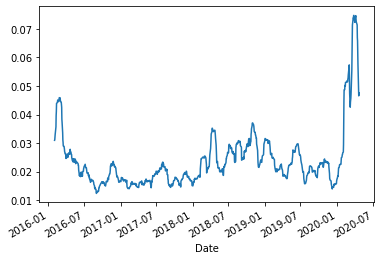

In [16]:
def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):

    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1) * \
        (np.log(np.divide(close_df, open_df))**2)

    x = x_hl + x_co.values

    gk = x.copy()

    const = 1/period

    gk.iloc[:period] = np.nan

    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row]))

    return gk

garman_klass = garman_klass_vol(df["High"], df["Low"], df["Close"], df["Open"], 20)
garman_klass.plot()

# 3. Lidando com portfolios

## Retorno

In [41]:
wallet = {
    'TSLA': .15, 
    'AMZN': .35, 
    'AAPL': .20, 
    'GOOG': .20
}
weights = np.array(list(wallet.values()))

In [95]:
wallet_time_series = data.DataReader(list(wallet.keys()), 
                     start='2016-1-1',
                     end='2020-4-22',
                     data_source='yahoo')

In [71]:
wallet_return = wallet_time_series.Close.pct_change()
wallet_return.head()

Symbols,TSLA,AMZN,AAPL,GOOG
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,0.029633,-0.012139,-0.009722,-0.004907
2020-01-06,0.019255,0.014886,0.007968,0.024657
2020-01-07,0.038801,0.002092,-0.004703,-0.000624
2020-01-08,0.049205,-0.007809,0.016086,0.007880


In [36]:
wallet_return.to_numpy().shape

(1083, 4)

In [72]:
wallet_return['return'] = np.dot(wallet_return.to_numpy(), weights)

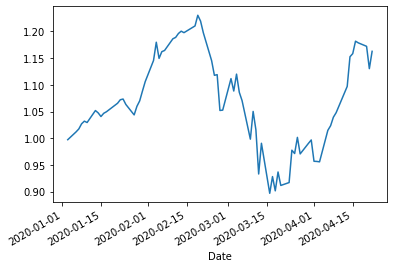

In [73]:
(1 + wallet_return['return']).cumprod().plot()

## Risco

In [74]:
wallet_return2 = wallet_return.drop(['return'], axis=1).dropna()
wallet_return2.head()

Symbols,TSLA,AMZN,AAPL,GOOG
Date,,,,
2020-01-03,0.029633,-0.012139,-0.009722,-0.004907
2020-01-06,0.019255,0.014886,0.007968,0.024657
2020-01-07,0.038801,0.002092,-0.004703,-0.000624
2020-01-08,0.049205,-0.007809,0.016086,0.007880
2020-01-09,-0.021945,0.004799,0.021241,0.011044


In [104]:
cov_matrix = np.cov(wallet_return2.T)

var_2 = np.dot(weights.T, np.dot(cov_matrix, weights))

print("Risco do portfólio: ", np.sqrt(var_2))

Risco do portfólio:  0.030510550057790176


In [129]:
def portfolio_risk(df_close, weights, start, end):
    df_close_return = df_close.loc[start:end].pct_change().dropna()
    
    cov_matrix = np.cov(df_close_return.T)
    var_2 = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    return np.sqrt(var_2)

In [ ]:
portfolio_risk(wallet_time_series.Close, weights, start = '2020-1-1', end = '2020-4-22')

## Teoria Moderna de Portifolio - Markowitz 

In [96]:
def markowitz(df_close, start, end, it = 5E3):
    expected_returns = []
    risks = []
    
    df_close_return = df_close.loc[start:end].pct_change().dropna()
    mean_returns = df_close_return.mean().to_numpy()
    
    cov_matrix = np.cov(df_close_return.T)

    for i in range(int(it)):
        # random wallet weights
        random_weights = np.random.rand(4)
        norm_weights = random_weights / sum(random_weights)
        
        # wallet risk
        var = np.dot(norm_weights.T, np.dot(cov_matrix, norm_weights))
        std = np.sqrt(var)
        risks.append(std)
        
        # expected return
        expected_returns.append(np.dot(mean_returns, norm_weights.T))
        
    return (risks, expected_returns)
    

In [99]:
risks, expected_returns = markowitz(df_close = wallet_time_series.Close, start = '2019-06-29', end = '2019-08-08')

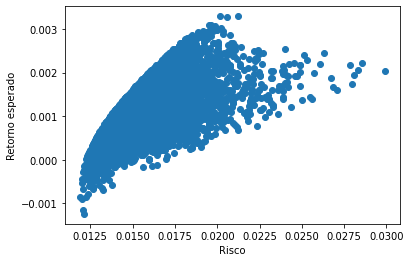

In [101]:
plt.scatter(risks, expected_returns)
plt.xlabel('Risco')
plt.ylabel('Retorno esperado')
plt.show()

# Predição de Time Series

Antes de iniciarmos a predição de time series, iremos abordar o conceito de sazonalidade.
Se uma serie temporal tem evidencias de não sazonalidade significa que ela muda suas propriedade estatisticas ao longo do tempo. É importante salientar que a covariacia não depende do tempo, ela apenas da distância das observações

- Gráfico com a média mudando ao longo do tempo.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Gráfico com o desvio padrão mudando ao longo do tempo

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- E por fim, neste gráfico podemos notar que a média e o desvio padrão permanencem constantes. Porém as distancia entre as observações varia.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Por que estamos falando de estacionalidade? Porque para realizar predições precisamos garantir que nossa série temporal mantem as caracteristicas estatisticas, pois usaremos elas para predizer os valores.

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plotagem da time series, Sua autocorrelação parcial e não parcial, 
        e calculado o teste de estacionalidade Dickey–Fuller test
        
        y - timeseries
        lags - Quantos lags serão inclusos nas autocorrelações
    """
    
    # verificando se o objeto é pandas
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):
        # instanciação da figura
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # p value to teste
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(df['Close'], 12)

## Cross validation em Séries Temporais

Sempre que lidamos com algoritmos de machine learning, para treina-lo temos que separar os datasets em treino e em teste. Em séries temporais não podemos separar os dados aleátoriamente pois a ordem de tempo importa! portanto seguimos a seguinte separação:

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

No sklearn já esta implementada a função de time series split!

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

Explicar a feature engineering de lag time series

In [ ]:
# Convertendo SeriesTime para DataFrame para criar mais colunas
df_lagged = pd.DataFrame(df["Close"].copy())
df_lagged.columns = ["y"]

for i in range(6 ,25):
    df_lagged["lag_{}".format(i)] = df_lagged.y.shift(i)

In [ ]:
df_lagged.tail()

In [ ]:
from sklearn.model_selection import cross_val_score

# time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Gera o train test split de serie temporal
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
y = df_lagged.dropna().y # target
X = df_lagged.dropna().drop(['y'], axis=1) # features

# train test split
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)